In [1]:
import os
import tarfile

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt

from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, random_split

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams["figure.facecolor"]="#ffffff"

In [2]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"

In [3]:
dataset_url

'https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz'

In [4]:
download_url(dataset_url, ".")

Using downloaded and verified file: ./cifar10.tgz


In [5]:
with tarfile.open("./cifar10.tgz", "r:gz") as tar:
    tar.extractall(path="./data")

In [6]:
data_dir = "./data/cifar10/"
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['deer', 'horse', 'frog', 'airplane', 'ship', 'cat', 'automobile', 'truck', 'dog', 'bird']


In [7]:
# Data transforms {normalization, data augmentation}
# ((mean, mean, mean), (std, std, std)) => {R,G,B}
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode="reflect"),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(),
                         tt.Normalize(*stats, inplace=True),
#                          tt.RandomRotate,
#                          tt.RandomResizedCrop(256, scale=(.5, .9), ratio=(1,1)),
#                          tt.ColorJitter(brightness=.1, contrast=.1, 
#                                         saturation=.1, hue=.1)
])

valid_tfms = tt.Compose([
    tt.ToTensor(),
    tt.Normalize(*stats)
])

In [8]:
# Dataset
train_ds = ImageFolder(data_dir+"/train", train_tfms)
val_ds = ImageFolder(data_dir+"/test", valid_tfms)

In [11]:
len(val_ds)

10000

In [12]:
type(val_ds)

torchvision.datasets.folder.ImageFolder

In [22]:
val_ds[0][0].shape

torch.Size([3, 32, 32])

In [39]:
img, label = val_ds[0]
print(img.shape, img.unsqueeze(0).shape)
print(label)

torch.Size([3, 32, 32]) torch.Size([1, 3, 32, 32])
0


In [47]:
if isinstance(img.unsqueeze(0), (list, tuple)):
    print("yes")
else:
    img_out = img.unsqueeze(0).to("cuda", non_blocking=True)
    print(img_out.device)

cuda:0


In [ ]:

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [9]:
# batch size
batch_size = 400

In [10]:
# dataloader
train_dl = DataLoader(train_ds, batch_size, shuffle=True, 
                      num_workers=3, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=3, pin_memory=True)

In [11]:
# denormalize the image and show the batch
def denorm(imgs, means, stds):
    means = torch.tensor(means).reshape(1,3,1,1)
    stds = torch.tensor(stds).reshape(1,3,1,1)
    return imgs * stds + means   # normed = (x - mean) / std

def show_batch(dl):
    for imgs, labels in dl:
        fig, ax = plt.subplots(figsize=(12,12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_imgs = denorm(imgs, *stats)
        ax.imshow(make_grid(denorm_imgs[:36], nrow=6).permute(1,2,0).clamp(0,1))
        break

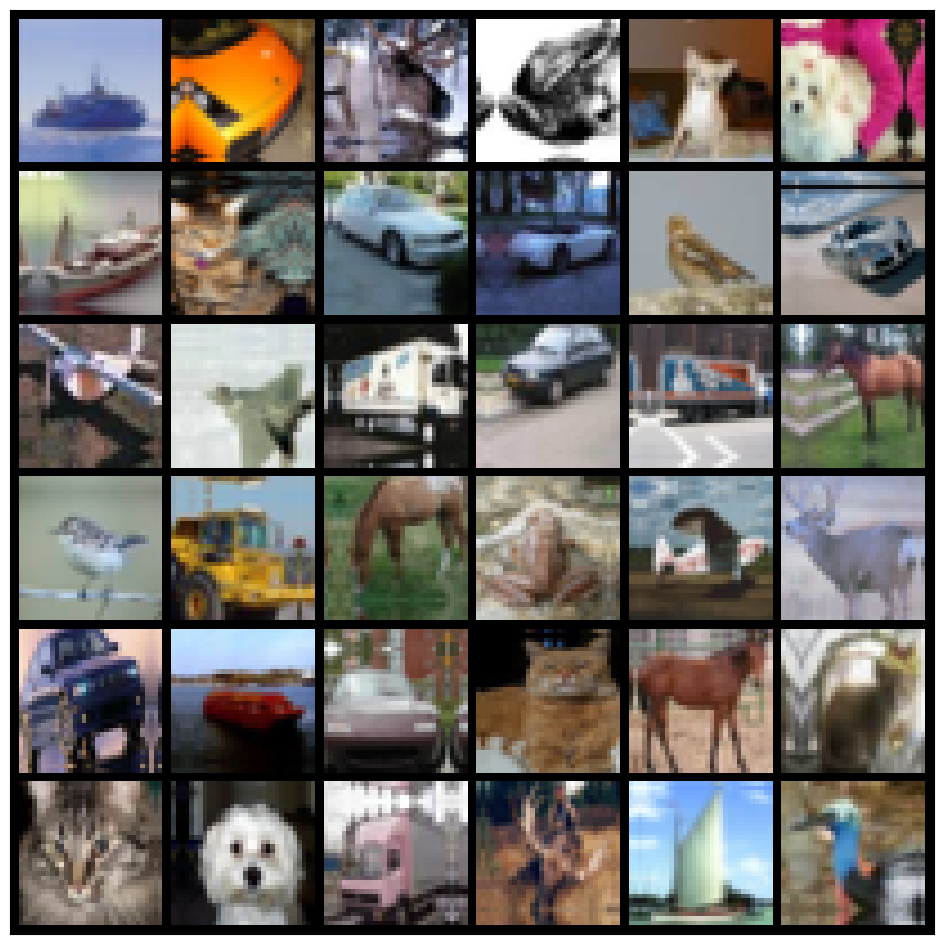

In [12]:
show_batch(train_dl)

In [31]:
# Device and to device
def get_default_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [32]:
# Device and dataloader
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl)

In [36]:
device = get_default_device()
device

device(type='cuda')

In [22]:
# wrap train and test with dataloader
train_on_device = DeviceDataLoader(train_dl, device)
val_on_device = DeviceDataLoader(valid_dl, device)

# Resnet 
https://github.com/JayPatwardhan/ResNet-PyTorch/tree/master/ResNet
https://machinelearningknowledge.ai/keras-implementation-of-resnet-50-architecture-from-scratch/#google_vignette
https://www.analyticsvidhya.com/blog/2021/06/build-resnet-from-scratch-with-python/

In [23]:
class SimplResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=3, 
            kernel_size=3, stride=1,
            padding=1
)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(
            in_channels=3, out_channels=3,
            kernel_size=3, stride=1,
            padding=1
)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        """
        Applying relu before or after adding the input
        """
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x

In [25]:
simple_resnet = to_device(SimplResidualBlock(), device)

for imgs, labels in train_on_device:
    out = simple_resnet(imgs)
    print(out.shape)
    break
    
del simple_resnet, imgs, labels

torch.Size([400, 3, 32, 32])


/home/loveplay1983/Workspace-22.04/Anaconda/envs/torch/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1695392022560/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


In [26]:
torch.cuda.empty_cache()

In [27]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [28]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        imgs, labels = batch
        out = self(imgs)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        imgs, labels = batch
        out = self(imgs)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {"val_loss" : loss.detach(), "val_acc": acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x["val_acc"] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [29]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

In [30]:
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [31]:
model = to_device(ResNet9(3, 10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [32]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [33]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

In [34]:
def fit_one_cycle(epochs, max_lr, model, 
                  train_loader, val_loader,
                  weight_decay=0, grad_clip=None,
                  opt_func=torch.optim.SGD
):
    torch.cuda.empty_cache()
    history = []
    
    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr,epochs=epochs,
                                                steps_per_epoch=len(train_loader)
    )
    
    
    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = [] 
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            if grad_clip:
                """ 
                Gradient clipping - keeping the gradient within a stable range 
                """
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # trace and update learning rate
            lrs.append(get_lr(optimizer)) # trace
            sched.step()  # update 
            
            
        # validation phase
        result = evaluate(model, val_loader)
        # trace training loss
        result["train_loss"] = torch.stack(train_losses).mean().item()
        # trace learning rate 
        result["lrs"] = lrs 
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history

In [35]:
history = [evaluate(model, val_on_device)]
history

[{'val_loss': 2.3075854778289795, 'val_acc': 0.09615384787321091}]

# Examining the device

In [36]:
if next(model.parameters()).is_cuda:
    print("on cuda")
else:
    print("on cpu")

on cuda


In [37]:
for each in val_on_device:
    print(each[0].device)
    break

cuda:0


In [38]:
print(val_on_device.device)

cuda


In [39]:
epochs = 8
max_lr = .01
grad_clip =.1
weight_decay=1e-4
opt_func = torch.optim.Adam

In [40]:
%%time
history += fit_one_cycle(epochs, max_lr, model, 
                         train_on_device, val_on_device,
                         grad_clip=grad_clip,
                         weight_decay=weight_decay,
                         opt_func=opt_func
)

Epoch [0], last_lr: 0.00393, train_loss: 1.5269, val_loss: 1.8123, val_acc: 0.4759
Epoch [1], last_lr: 0.00935, train_loss: 1.0880, val_loss: 1.3893, val_acc: 0.5976
Epoch [2], last_lr: 0.00972, train_loss: 0.8699, val_loss: 0.8112, val_acc: 0.7237
Epoch [3], last_lr: 0.00812, train_loss: 0.6394, val_loss: 0.8243, val_acc: 0.7383
Epoch [4], last_lr: 0.00556, train_loss: 0.5078, val_loss: 0.4804, val_acc: 0.8385
Epoch [5], last_lr: 0.00283, train_loss: 0.3965, val_loss: 0.3922, val_acc: 0.8598
Epoch [6], last_lr: 0.00077, train_loss: 0.3006, val_loss: 0.3180, val_acc: 0.8890
Epoch [7], last_lr: 0.00000, train_loss: 0.2206, val_loss: 0.2815, val_acc: 0.9058
CPU times: user 4min 15s, sys: 2min 32s, total: 6min 48s
Wall time: 6min 56s


In [41]:
def plot_result(history):
#     fig = plt.figure(figsize=(x,y))
    fig, axs = plt.subplots(1,3, figsize=(10, 3))
    
    # plot acc
    acc = [x["val_acc"] for x in history]
    axs[0].plot(acc, color="gray", marker="o", 
                mfc="green", mec="green")
    axs[0].set_title("accuracy")
    axs[0].set_xlabel("epoch")
    axs[0].set_ylabel("accuracy")
    
    
    # plot train loss
    train_loss = [x.get('train_loss') for x in history]
    axs[1].plot(train_loss, color="gray", marker="o", 
                mfc="black", mec="black")
    axs[1].set_title("train_loss")
    axs[1].set_xlabel("epoch")
    axs[1].set_ylabel("train_loss")
    axs[1].set_xticks(np.arange(0, 10))
    
    
    # plot val loss
    val_loss = [x.get('val_loss') for x in history]
    axs[2].plot(train_loss, color="gray", marker="o", 
                mfc="red", mec="red")
    axs[2].set_title("val_loss")
    axs[2].set_xlabel("epoch")
    axs[2].set_ylabel("val_loss")
    axs[2].set_xticks(np.arange(0, 10))
    
#     plt.tight_layout()
    plt.show()

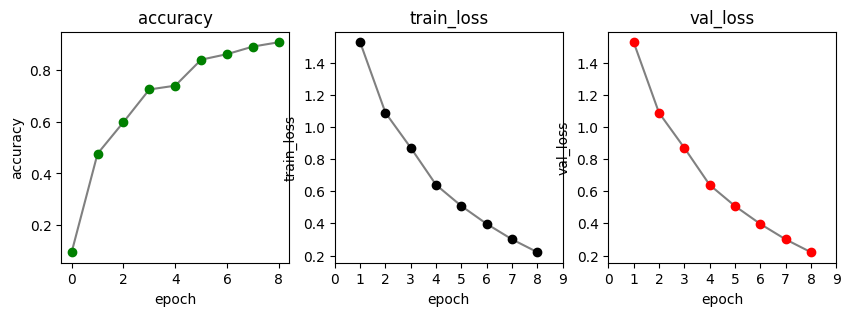

In [42]:
plot_result(history)

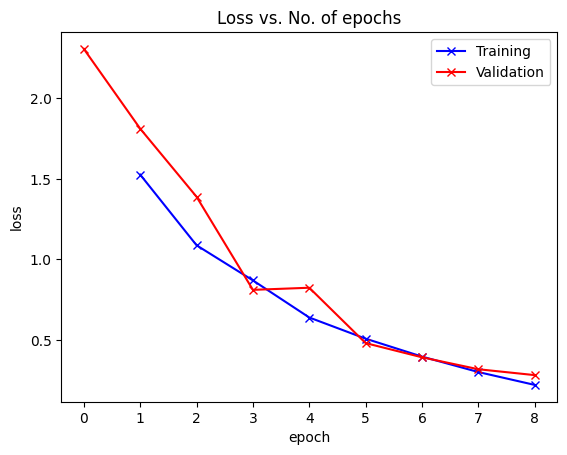

In [43]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
plot_losses(history)

In [50]:
def plot_lrs(history):
    lrs = np.concatenate([x.get("lrs", []) for x in history])
    plt.plot(lrs)
    plt.xlabel("Batch no.")
    plt.ylabel("Learning rate")
    plt.title("Learning rate vs. batch no.")

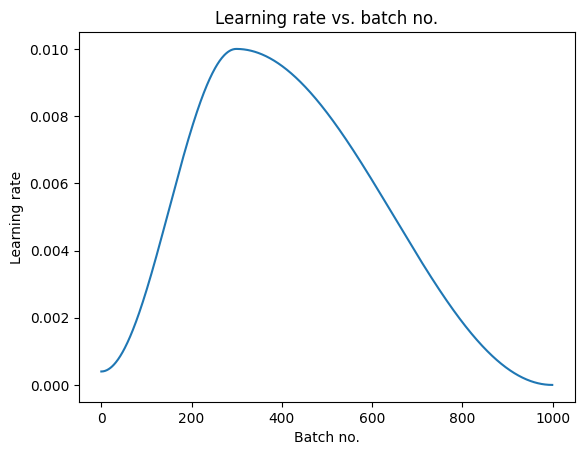

In [51]:
plot_lrs(history)

In [56]:
def predict_img(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    # return target label by the index of prediction
    return train_ds.classes[preds[0].item()] 

Label: airplane , Predicted: airplane


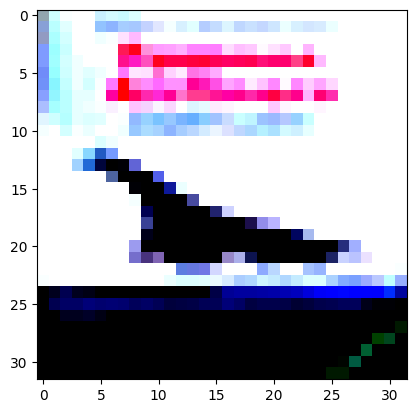

In [57]:
img, label = val_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_img(img, model))

Label: automobile , Predicted: automobile


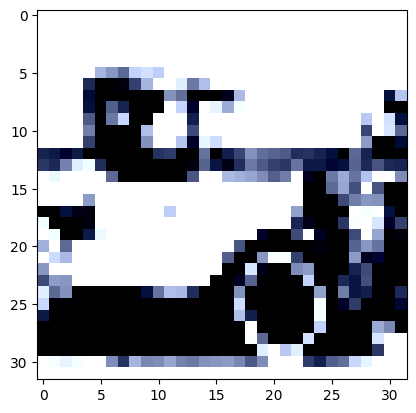

In [58]:
img, label = val_ds[1002]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_img(img, model))

In [59]:
torch.save(model.state_dict(), 'cifar10-resnet9.pth')